# Loan Prediction Practice Problem
Analytics Vidhya Course [Link](https://courses.analyticsvidhya.com/courses/loan-prediction-practice-problem-using-python)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline

In [2]:
warnings.filterwarnings("ignore")

In [3]:
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")

In [4]:
train_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [5]:
test_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


In [6]:
train_cpy = train_df.copy()
test_cpy = test_df.copy()

# EDA

## Univariate Analysis

In [7]:
train_df.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [8]:
train_df.shape

(614, 13)

In [9]:
test_df.shape

(367, 12)

### Target variable

In [10]:
train_df['Loan_Status'].value_counts()

Y    422
N    192
Name: Loan_Status, dtype: int64

In [11]:
train_df['Loan_Status'].value_counts(normalize=True)

Y    0.687296
N    0.312704
Name: Loan_Status, dtype: float64

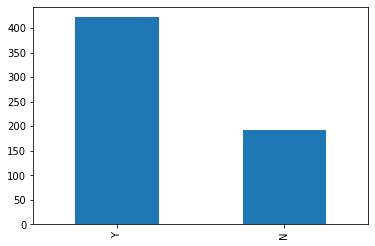

In [12]:
train_df['Loan_Status'].value_counts().plot.bar();

### Independent variable (Categorical)

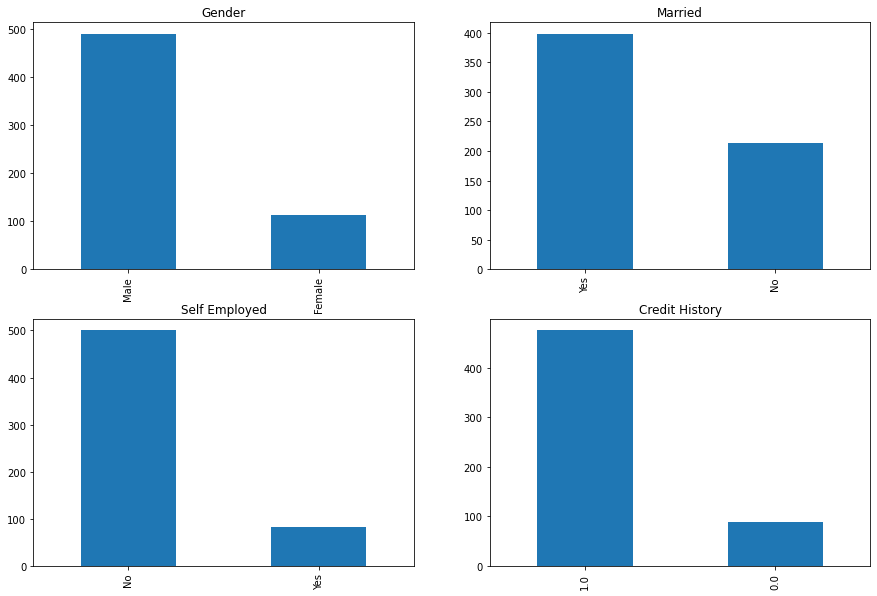

In [13]:
plt.figure(figsize=(15, 10))

plt.subplot(221)
train_df['Gender'].value_counts().plot.bar(title='Gender');

plt.subplot(222)
train_df['Married'].value_counts().plot.bar(title='Married');

plt.subplot(223)
train_df['Self_Employed'].value_counts().plot.bar(title='Self Employed');

plt.subplot(224)
train_df['Credit_History'].value_counts().plot.bar(title='Credit History');

plt.show()

### Independent Variable (Ordinal)

<AxesSubplot: title={'center': 'Prope'}>

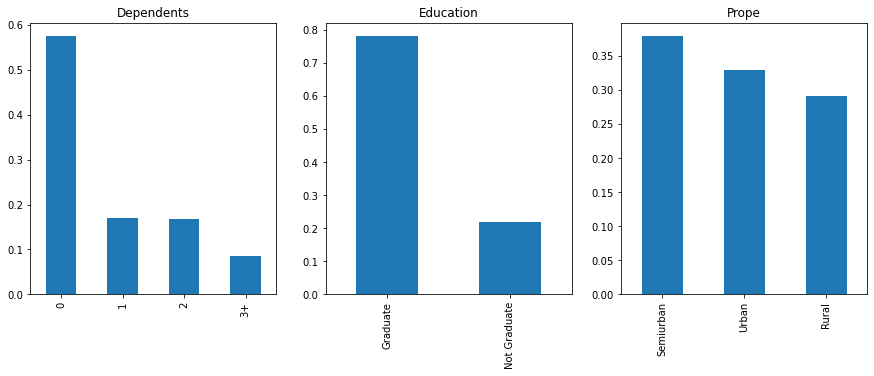

In [14]:
plt.figure(figsize=(15, 5))

plt.subplot(131)
train_df['Dependents'].value_counts(normalize=True).plot.bar(title='Dependents');

plt.subplot(132)
train_df['Education'].value_counts(normalize=True).plot.bar(title='Education');

plt.subplot(133)
train_df['Property_Area'].value_counts(normalize=True).plot.bar(title='Prope')

### Independent Variable (Numerical)

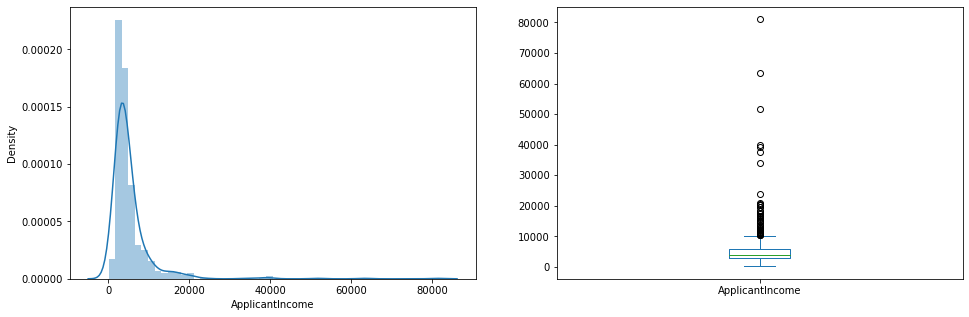

In [17]:
plt.figure(1)

plt.subplot(121)
sns.distplot(train_df['ApplicantIncome']);

plt.subplot(122)
train_df['ApplicantIncome'].plot.box(figsize=(16, 5))

plt.show()

Text(0.5, 0.98, '')

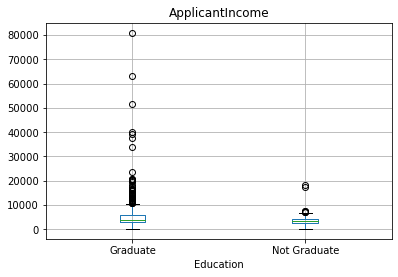

In [21]:
train_df.boxplot(column="ApplicantIncome", by="Education")
plt.suptitle("")

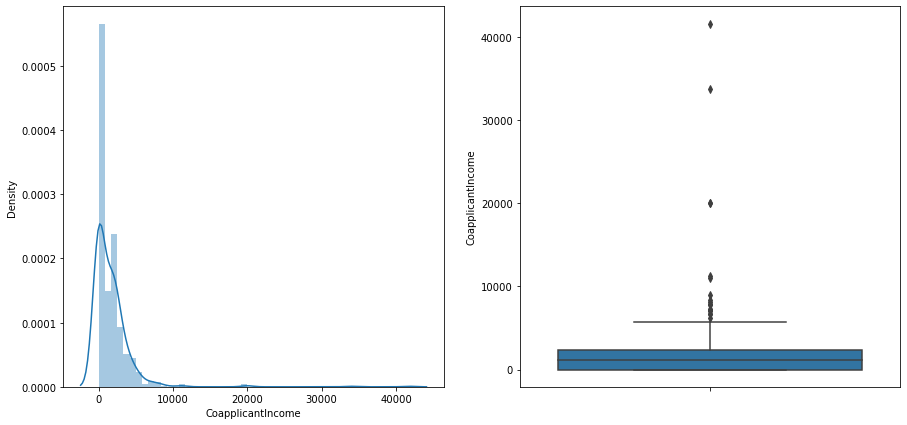

In [32]:
plt.figure(figsize=(15, 7))

plt.subplot(121)
sns.distplot(train_df['CoapplicantIncome']);

plt.subplot(122)
sns.boxplot(data=train_df, y="CoapplicantIncome")

plt.show()

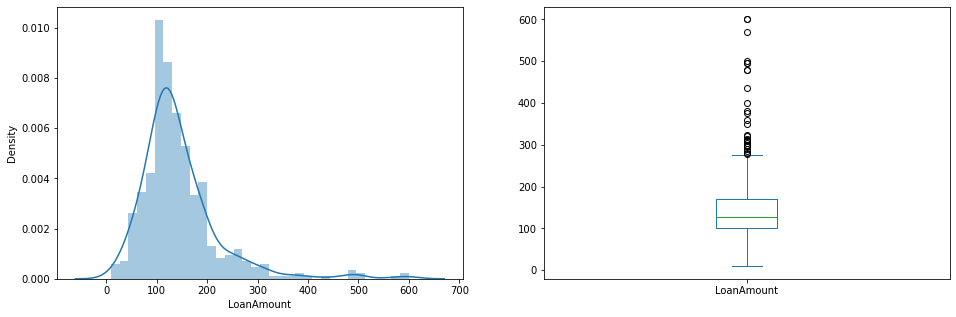

In [33]:
plt.figure(1)

plt.subplot(121)
df = train_df.dropna()
sns.distplot(df['LoanAmount']);

plt.subplot(122)
df['LoanAmount'].plot.box(figsize=(16, 5))

plt.show()

## Bivariate Analysis

### Categorical Independent Variable vs Target Variable